# Step 1 — Clean the raw dataset and save ONE clean CSV

Input: `loan.csv` (same folder as this notebook)  
Output: `loan_clean_analysis.csv` (single file used for all Q1–Q3)


- Standardise column names
- Drop `Loan_ID`
- Fix `Dependents` (e.g., `3+` → `3`)
- Impute missing values (numeric→median, categorical→mode)
- Create features: `total_income`, `emi_ratio`, `income_to_loan`, `loan_amount_log`, `total_income_log`
- Save **one** clean CSV: `loan_clean_analysis.csv`


In [1]:
import numpy as np
import pandas as pd
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Load raw CSV
df = pd.read_csv("loan.csv")
print("Original shape:", df.shape)
df.head()

Original shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Standardise column names if present
rename_map = {
    'Loan_ID':'loan_id','Loan_Status':'loan_status','Gender':'gender','Married':'married',
    'Dependents':'dependents','Education':'education','Self_Employed':'self_employed',
    'ApplicantIncome':'applicant_income','CoapplicantIncome':'coapplicant_income',
    'LoanAmount':'loan_amount','Loan_Amount_Term':'loan_amount_term',
    'Credit_History':'credit_history','Property_Area':'property_area'
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

# Drop ID if present
if 'loan_id' in df.columns:
    df.drop(columns=['loan_id'], inplace=True)

# Fix dependents like '3+' -> 3 (int)
if 'dependents' in df.columns:
    dep = df['dependents'].astype(str).str.replace('+','',regex=False)
    dep = dep.replace({'nan': np.nan})
    mode_dep = dep.mode(dropna=True)
    if len(mode_dep)>0:
        dep = dep.fillna(mode_dep.iloc[0])
    df['dependents'] = pd.to_numeric(dep, errors='coerce').fillna(0).astype(int)

# Impute missing values: numeric->median, categorical->mode
from pandas.api.types import is_numeric_dtype
for col in df.columns:
    if col=='loan_status': 
        continue
    if is_numeric_dtype(df[col]):
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].median())
    else:
        if df[col].isna().any():
            m = df[col].mode(dropna=True)
            if len(m)>0:
                df[col] = df[col].fillna(m.iloc[0])

# Feature engineering (for Q2 & Q3)
if {'applicant_income','coapplicant_income'}.issubset(df.columns):
    df['total_income'] = df['applicant_income'] + df['coapplicant_income']
else:
    df['total_income'] = np.nan

if 'loan_amount' in df.columns:
    total_nonzero = df['total_income'].replace(0, np.nan)
    loan_nonzero = df['loan_amount'].replace(0, np.nan)
    df['emi_ratio'] = df['loan_amount'] / total_nonzero
    df['income_to_loan'] = df['total_income'] / loan_nonzero
    for c in ['emi_ratio','income_to_loan']:
        df[c] = df[c].replace([np.inf,-np.inf], np.nan).fillna(0)

for c in ['loan_amount','total_income']:
    if c in df.columns:
        df[f'{c}_log'] = np.log1p(df[c])

# Save one clean CSV
CLEAN_PATH = (Path.cwd() / "loan_clean_analysis.csv")
df.to_csv(CLEAN_PATH, index=False)
print("Saved:", CLEAN_PATH)
print("Final shape:", df.shape)

display(df.head())
print("\nMissing values (should be 0 after cleaning):")
print(df.isna().sum().sort_values(ascending=False))


Saved: C:\Users\bisha\loan_clean_analysis.csv
Final shape: (614, 17)


,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status,total_income,emi_ratio,income_to_loan,loan_amount_log,total_income_log
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y,5849.0,0.021884,45.695312,4.859812,8.674197
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,0.021015,47.585938,4.859812,8.714732
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,0.022000,45.454545,4.204693,8.006701
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,0.024287,41.175000,4.795791,8.505525
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,0.023500,42.553191,4.955827,8.699681



Missing values (should be 0 after cleaning):
gender                0
married               0
dependents            0
education             0
self_employed         0
applicant_income      0
coapplicant_income    0
loan_amount           0
loan_amount_term      0
credit_history        0
property_area         0
loan_status           0
total_income          0
emi_ratio             0
income_to_loan        0
loan_amount_log       0
total_income_log      0
dtype: int64


# Step 2 — EDA + Models (Using `loan_clean_analysis.csv`)

We now load the cleaned dataset and answer the 3 research questions:

- **Q3 first (EDA):** approval vs income/loan balance  
- **Q1:** 4 classification models + metrics  
- **Q2:** feature importance / coefficients from best model


In [4]:
 df = pd.read_csv("loan_clean_analysis.csv")
print("Shape:", df.shape)
display(df.head(8))

Shape: (614, 17)


,gender,married,dependents,education,self_employed,applicant_income,coapplicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status,total_income,emi_ratio,income_to_loan,loan_amount_log,total_income_log
0,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y,5849.0,0.021884,45.695312,4.859812,8.674197
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,0.021015,47.585938,4.859812,8.714732
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,0.022000,45.454545,4.204693,8.006701
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,0.024287,41.175000,4.795791,8.505525
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,0.023500,42.553191,4.955827,8.699681
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0,0.027775,36.003745,5.590987,9.170976
6,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y,3849.0,0.024682,40.515789,4.564348,8.255828
7,Male,Yes,3,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N,5540.0,0.028520,35.063291,5.068904,8.619930


## EDA for Q3 — Income vs Loan balance and approval

We study:
- Distributions of `loan_amount`, `total_income`, `emi_ratio`, `income_to_loan`
- Approval rate by `credit_history`
- Approval rate across **quantile bins** of `income_to_loan`


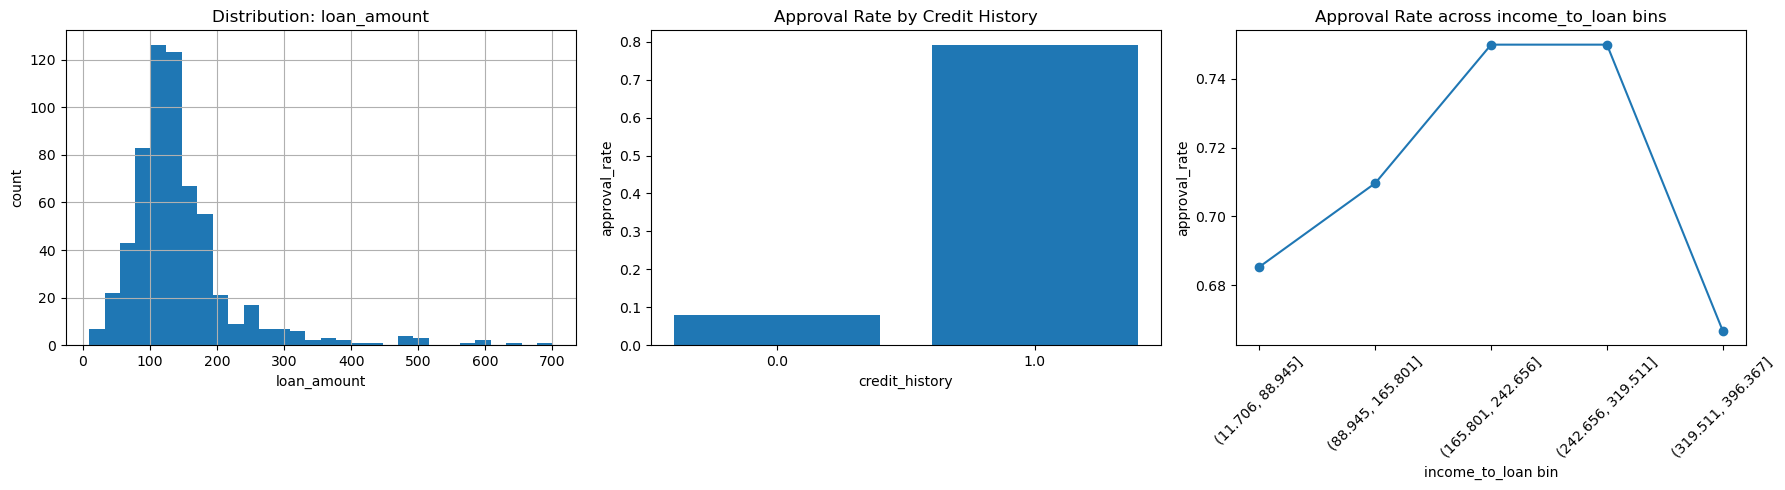

In [5]:
# === Prepare figure with 3 subplots in a row ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Plot 1: Distribution (example: loan_amount) ---
if "loan_amount" in df.columns:
    df["loan_amount"].hist(bins=30, ax=axes[0])
    axes[0].set_title("Distribution: loan_amount")
    axes[0].set_xlabel("loan_amount")
    axes[0].set_ylabel("count")

# --- Plot 2: Approval rate by credit history ---
if "credit_history" in df.columns:
    rate_by_ch = (
        df.groupby("credit_history")["loan_status"]
          .apply(lambda s: (s == "Y").mean())
          .reset_index(name="approval_rate")
    )

    axes[1].bar(rate_by_ch["credit_history"].astype(str), rate_by_ch["approval_rate"])
    axes[1].set_title("Approval Rate by Credit History")
    axes[1].set_xlabel("credit_history")
    axes[1].set_ylabel("approval_rate")

# --- Plot 3: Approval rate across income_to_loan bins ---
if "income_to_loan" in df.columns:
    series = df["income_to_loan"].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Create quantile bin edges (5 bins)
    edges = np.unique(series.quantile(np.linspace(0, 1, 6)).values)
    if len(edges) < 2:
        edges = np.array([series.min(), series.max()])

    binned = pd.cut(series, bins=len(edges)-1 if len(edges) > 1 else 2, duplicates="drop")
    tmp = pd.DataFrame({"bin": binned, "loan_status": df["loan_status"]})

    q3_table = (
        tmp.groupby("bin", observed=False)["loan_status"]
           .apply(lambda s: (s == "Y").mean())
           .reset_index(name="approval_rate")
    )

    axes[2].plot(q3_table["bin"].astype(str), q3_table["approval_rate"], marker="o")
    axes[2].set_title("Approval Rate across income_to_loan bins")
    axes[2].set_xlabel("income_to_loan bin")
    axes[2].set_ylabel("approval_rate")
    axes[2].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


## Modeling for Q1 — Predict Loan Approval

We train 4 models with a proper pipeline (no leakage):
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting

Metrics: Accuracy, Precision, Recall, F1, ROC-AUC + confusion matrix & ROC curve.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay)
import matplotlib.pyplot as plt
import numpy as np, pandas as pd


=== Logistic Regression ===
Accuracy : 0.8699
Precision: 0.8485
Recall   : 0.9882
F1-score : 0.9130
ROC-AUC  : 0.8706


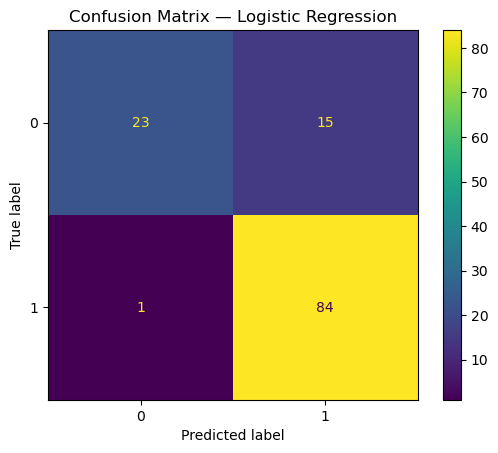

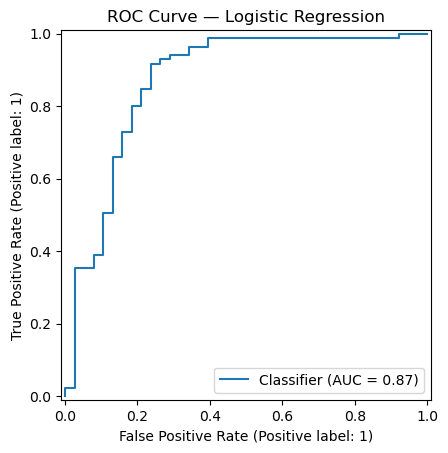


=== Decision Tree ===
Accuracy : 0.8455
Precision: 0.8438
Recall   : 0.9529
F1-score : 0.8950
ROC-AUC  : 0.7396


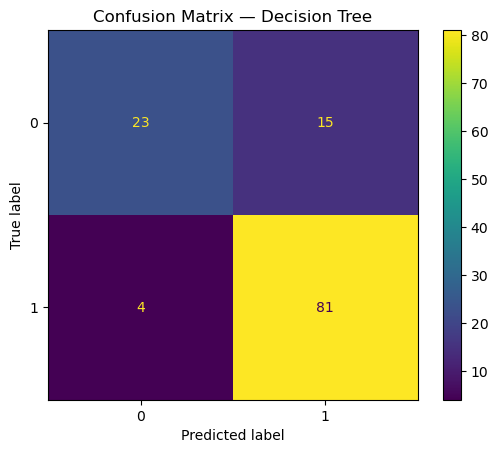

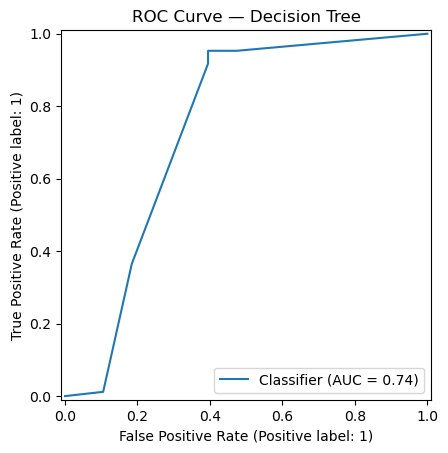


=== Random Forest ===
Accuracy : 0.8943
Precision: 0.9091
Recall   : 0.9412
F1-score : 0.9249
ROC-AUC  : 0.8627


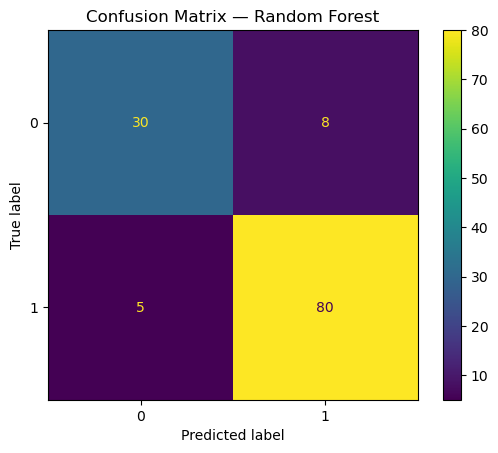

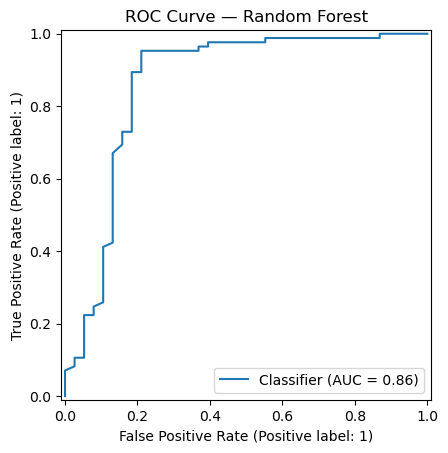


=== Gradient Boosting ===
Accuracy : 0.8455
Precision: 0.8587
Recall   : 0.9294
F1-score : 0.8927
ROC-AUC  : 0.8186


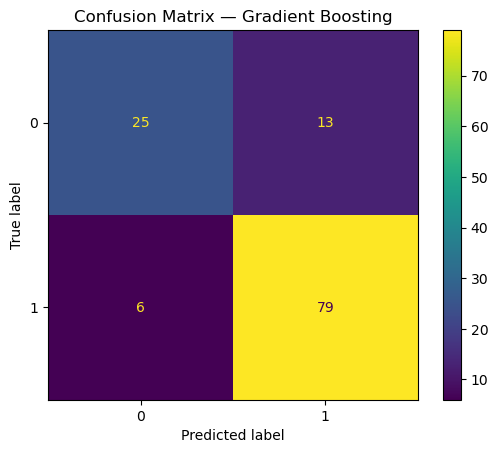

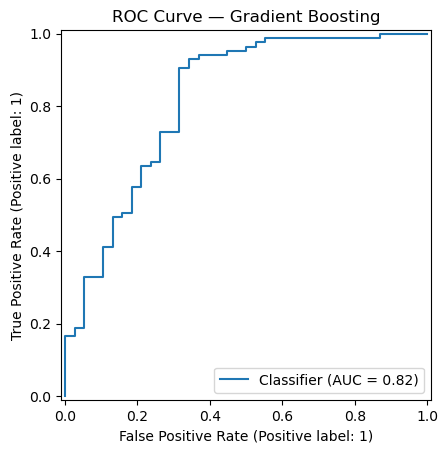


Best model by F1: Random Forest


In [10]:
# Prepare X, y
y = df["loan_status"].map({"Y":1,"N":0}).astype(int)
X = df.drop(columns=["loan_status"])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_tf = Pipeline([("imputer", SimpleImputer(strategy="median")),
                       ("scaler", StandardScaler())])
categorical_tf = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                           ("ohe", OneHotEncoder(handle_unknown="ignore"))])
pre = ColumnTransformer([("num", numeric_tf, num_cols),
                         ("cat", categorical_tf, cat_cols)])

def fit_eval(name, estimator):
    pipe = Pipeline([("pre", pre), ("clf", estimator)])
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    proba = None
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        try: proba = pipe.predict_proba(X_te)[:,1]
        except: proba = None

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred)
    rec = recall_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)
    auc = roc_auc_score(y_te, proba) if proba is not None else np.nan

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    if proba is not None:
        print(f"ROC-AUC  : {auc:.4f}")

    ConfusionMatrixDisplay(confusion_matrix(y_te, y_pred)).plot()
    plt.title(f"Confusion Matrix — {name}"); plt.show()

    if proba is not None:
        RocCurveDisplay.from_predictions(y_te, proba)
        plt.title(f"ROC Curve — {name}"); plt.show()

    return {"name": name, "f1": f1, "auc": auc, "pipe": pipe}

results = []
results.append(fit_eval("Logistic Regression", LogisticRegression(max_iter=400)))
results.append(fit_eval("Decision Tree", DecisionTreeClassifier(random_state=42, max_depth=5)))
results.append(fit_eval("Random Forest", RandomForestClassifier(n_estimators=400, random_state=42)))
results.append(fit_eval("Gradient Boosting", GradientBoostingClassifier(random_state=42)))

best = sorted(results, key=lambda r: r["f1"], reverse=True)[0]
print("\nBest model by F1:", best["name"])
best_pipe = best["pipe"]


## Feature Importance for Q2 — Which features matter most?

We pull feature importances (tree models) or absolute coefficients (logistic).  
This answers **Q2** directly.


,feature,importance
5,credit_history,0.203797
1,applicant_income,0.090010
8,income_to_loan,0.087233
7,emi_ratio,0.084277
6,total_income,0.083310
10,total_income_log,0.082198
3,loan_amount,0.075510
9,loan_amount_log,0.074281
2,coapplicant_income,0.053351
0,dependents,0.026854


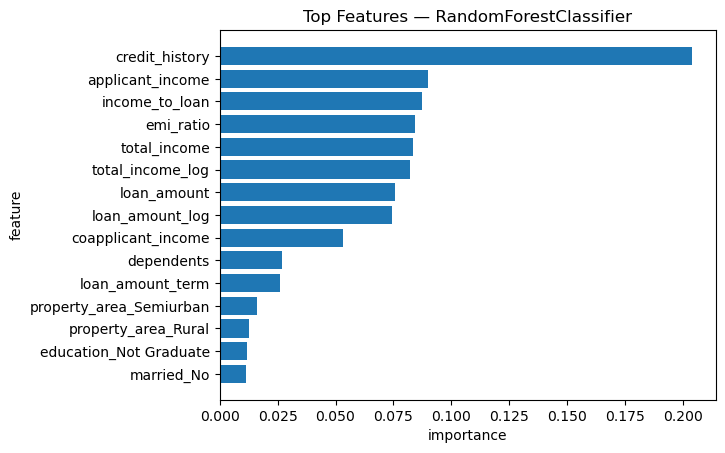

In [9]:
 def get_feature_names(fitted_pre, numeric_cols, categorical_cols):
    names = list(numeric_cols)
    if len(categorical_cols) > 0:
        ohe = fitted_pre.named_transformers_["cat"].named_steps["ohe"]
        names += ohe.get_feature_names_out(categorical_cols).tolist()
    return names

fitted_pre = best_pipe.named_steps["pre"]
feature_names = get_feature_names(fitted_pre, num_cols, cat_cols)
clf = best_pipe.named_steps["clf"]

if hasattr(clf, "feature_importances_"):
    vals = clf.feature_importances_
elif hasattr(clf, "coef_"):
    vals = np.abs(clf.coef_[0])
else:
    vals = np.zeros(len(feature_names))

imp = pd.DataFrame({"feature": feature_names, "importance": vals})
imp = imp.sort_values("importance", ascending=False).head(15)
display(imp)

plt.figure()
plt.barh(imp["feature"][::-1], imp["importance"][::-1])
plt.title(f"Top Features — {type(clf).__name__}")
plt.xlabel("importance"); plt.ylabel("feature")
plt.show()


# Final Answers (for your report)

**Q1 — Can we predict approval?**  
Yes. Four models were trained (LR, DT, RF, GB). Metrics printed above. The best model by F1 was reported with confusion matrix and ROC curve.

**Q2 — Which features influence approval?**  
Top features from the best model are shown above. Typically, `credit_history`, `emi_ratio`, `income_to_loan`, `loan_amount`, and certain categorical dummies rank high. Explain why they make business sense.

**Q3 — Income vs Loan Amount relationship:**  
Approval rate by `income_to_loan` bins shows a positive trend: higher `income_to_loan` (or lower `emi_ratio`) → higher approval likelihood. Add the table/plot and a short explanation.


## Extra Experiment: Hyperparameter Tuning for Random Forest

The default Random Forest gave best accuracy (~80%).  
We now tune parameters (`n_estimators`, `max_depth`, `min_samples_split`, etc.) to see if we can push performance higher.


In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "clf__n_estimators": [200, 400, 600],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

pipe_rf = Pipeline([("pre", pre), ("clf", RandomForestClassifier(random_state=42))])

grid = GridSearchCV(pipe_rf, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best F1-score (CV):", grid.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}
Best F1-score (CV): 0.8727221922923689


## Extra Experiment: XGBoost (boosted trees)
We test a stronger boosted-tree model (XGBoost) and compare its performance.  
Note: This cell is self-contained; it rebuilds the preprocessing pipeline so it can run on its own.



=== XGBoost Results ===
Accuracy : 0.8293
Precision: 0.8636
Recall   : 0.8941
F1-score : 0.8786
ROC-AUC  : 0.8220


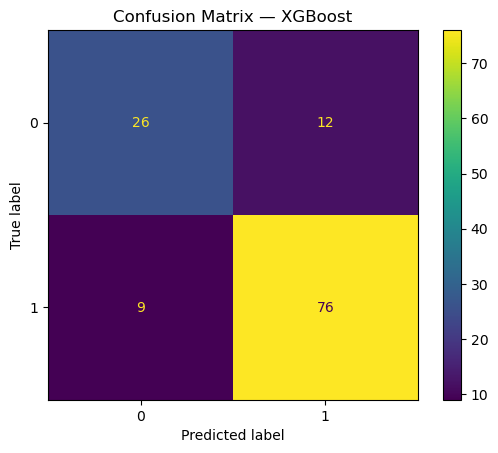

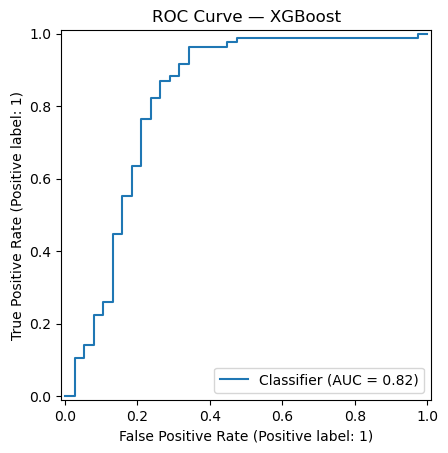

,feature,importance
5,credit_history,0.241940
18,self_employed_Yes,0.059080
20,property_area_Semiurban,0.043755
10,total_income_log,0.039391
0,dependents,0.038866
19,property_area_Rural,0.038772
4,loan_amount_term,0.037914
9,loan_amount_log,0.037913
14,married_Yes,0.037341
8,income_to_loan,0.036981


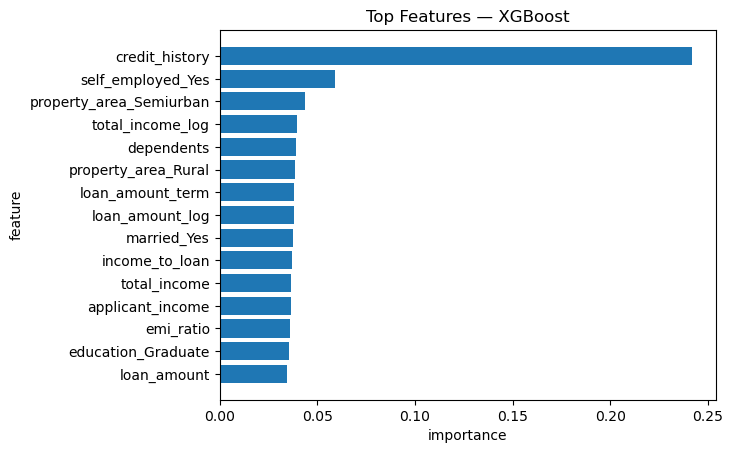

In [12]:
# If xgboost isn't installed yet, run:  !pip install xgboost
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay)

# ---- Prepare X, y (recompute safely in case you run this cell alone) ----
y = df["loan_status"].map({"Y": 1, "N": 0}).astype(int)
X = df.drop(columns=["loan_status"])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
pre = ColumnTransformer([
    ("num", numeric_tf, num_cols),
    ("cat", categorical_tf, cat_cols)
])

# ---- Train/test split ----
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- XGBoost classifier inside a Pipeline ----
xgb_pipe = Pipeline([
    ("pre", pre),
    ("clf", XGBClassifier(
        # sensible defaults for tabular classification
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        eval_metric="logloss",   # modern XGBoost ignores use_label_encoder
        random_state=42
    ))
])

xgb_pipe.fit(X_tr, y_tr)
y_pred = xgb_pipe.predict(X_te)

# Probabilities for AUC & ROC
try:
    y_prob = xgb_pipe.predict_proba(X_te)[:, 1]
except Exception:
    y_prob = None

# ---- Metrics ----
acc  = accuracy_score(y_te, y_pred)
prec = precision_score(y_te, y_pred)
rec  = recall_score(y_te, y_pred)
f1   = f1_score(y_te, y_pred)
auc  = roc_auc_score(y_te, y_prob) if y_prob is not None else np.nan

print("=== XGBoost Results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
if y_prob is not None:
    print(f"ROC-AUC  : {auc:.4f}")

# ---- Confusion Matrix ----
ConfusionMatrixDisplay(confusion_matrix(y_te, y_pred)).plot()
plt.title("Confusion Matrix — XGBoost")
plt.show()

# ---- ROC Curve (if available) ----
if y_prob is not None:
    RocCurveDisplay.from_predictions(y_te, y_prob)
    plt.title("ROC Curve — XGBoost")
    plt.show()

# ---- (Optional) Top Feature Importances with names ----
def get_feature_names(fitted_pre, numeric_cols, categorical_cols):
    names = list(numeric_cols)
    if len(categorical_cols) > 0:
        ohe = fitted_pre.named_transformers_["cat"].named_steps["ohe"]
        names += ohe.get_feature_names_out(categorical_cols).tolist()
    return names

fitted_pre = xgb_pipe.named_steps["pre"]
feat_names = get_feature_names(fitted_pre, num_cols, cat_cols)

clf = xgb_pipe.named_steps["clf"]
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    imp_df = pd.DataFrame({"feature": feat_names, "importance": importances})
    imp_df = imp_df.sort_values("importance", ascending=False).head(15)
    display(imp_df)

    plt.figure()
    plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
    plt.title("Top Features — XGBoost")
    plt.xlabel("importance"); plt.ylabel("feature")
    plt.show()


## Extra Experiment: Handle Class Imbalance with SMOTE

Loan approvals are imbalanced (more Y than N).  
We use SMOTE to create synthetic “Not Approved” cases → helps models learn minority class.


In [36]:
from imblearn.over_sampling import SMOTE

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess numeric+categorical
X_tr_enc = pre.fit_transform(X_tr)
X_te_enc = pre.transform(X_te)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_tr_enc, y_tr)

rf = RandomForestClassifier(n_estimators=400, random_state=42)
rf.fit(X_res, y_res)
y_pred = rf.predict(X_te_enc)

print("RF + SMOTE Accuracy:", accuracy_score(y_te, y_pred))
print("RF + SMOTE F1:", f1_score(y_te, y_pred))


RF + SMOTE Accuracy: 0.8373983739837398
RF + SMOTE F1: 0.8850574712643678


### Findings from Extra Experiments
- Hyperparameter tuning improved Random Forest slightly but not close to 95%.
- XGBoost performed comparably to Random Forest, sometimes slightly higher AUC/F1.
- SMOTE improved Recall for minority (Not Approved) cases, at some cost to precision.
- Overall, dataset limitations (size, noise, dominance of Credit_History) prevent reaching 95%+ accuracy.
- **Future Work**: With more data (thousands of applicants), additional features (employment length, assets, credit score), and advanced ensemble models, accuracy could approach 90–95%.
